### 1. 기본 설정 & 임포트

In [9]:
# === 기본 설정 & 임포트 ===
import os, re, json, math, gc, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import HistGradientBoostingRegressor

RANDOM_STATE = 42
VALID_SIZE = 0.30

# 너가 사전에 설정한 경로 변수를 사용 (예: TRAIN_PATH = "train.tsv"; TEST_PATH = "test.tsv")
# assert 'TRAIN_PATH' in globals() and 'TEST_PATH' in globals()
TRAIN_PATH = 'mercari_data/train.tsv'
TEST_PATH = 'mercari_data/test.tsv'
ARTIFACT_DIR = Path("./artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

def log(msg): 
    print(f"[INFO] {msg}")


### 2. 유틸 함수 : 텍스트 정규화/토큰, 안전 함수

In [10]:
# === 텍스트 정규화 유틸 ===
import unicodedata
def normalize_text(t: str) -> str:
    if not isinstance(t, str):
        t = "" if pd.isna(t) else str(t)
    t = t.lower()
    t = unicodedata.normalize("NFKD", t)
    t = "".join(ch for ch in t if not unicodedata.combining(ch))
    t = re.sub(r"[\u2600-\u27BF]+", " ", t)  # emojis
    t = re.sub(r"[^a-z0-9$+\-.,%&/()' *:_]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def safe_len_words(s: str) -> int:
    try:
        return len(str(s).split())
    except Exception:
        return 0


### 3. 데이터 로딩 & 기본 클린업

In [11]:
# === 데이터 로딩 & 기본 클린업 ===
log("Loading data...")
df = pd.read_csv(TRAIN_PATH, sep="\t")

# 1) category_name 결측 드롭
df = df.dropna(subset=["category_name"]).copy()

# 2) item_description 결측 대체
df["item_description"] = df["item_description"].fillna("No description yet").astype(str).str.strip()

# 3) 카테고리 분해 cat1/cat2/cat3
spl = df["category_name"].str.split("/", expand=True)
df["cat1"], df["cat2"], df["cat3"] = spl[0], spl[1], spl[2]

# 4) 브랜드 결측: 일단 그대로 두고(후보 보강 후), 최종 없으면 no_brand
#    우선은 문자열 정규화만
df["brand_name"] = df["brand_name"].astype(str).str.strip()

# 5) 타깃
df["price"] = df["price"].clip(lower=1)
df["y"] = np.log1p(df["price"])

log(f"Rows after drop: {len(df):,}")
df.head(3)


[INFO] Loading data...
[INFO] Rows after drop: 1,476,208


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat1,cat2,cat3,y
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,nan,10.0,1,No description yet,Men,Tops,T-shirts,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3.970292
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,2.397895


### 4. 중분류(cat2) 단위 IQR 이상치 처리 (선택: winsorize 주석 제공)

In [12]:
# === cat2 단위 IQR 이상치 처리 ===
def iqr_filter_by_group(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s >= lo) & (s <= hi)

mask = df.groupby("cat2")["price"].transform(iqr_filter_by_group)
removed = (~mask).sum()
log(f"Outliers removed by IQR: {removed:,}")

df = df[mask].copy()
df.reset_index(drop=True, inplace=True)

# (대안) 제거율이 과하면 아래처럼 cat2별 winsorize로 대체
# df["price"] = df.groupby("cat2")["price"].transform(lambda s: s.clip(s.quantile(.01), s.quantile(.99)))
# df["y"] = np.log1p(df["price"])


[INFO] Outliers removed by IQR: 103,684


### 5. 브랜드 사전 구축(상위 N개) & 액세서리/호환문맥 규칙 기반 브랜드 보강

In [13]:
# === 브랜드 보강: 사전 + 규칙 ===
# 상위 빈도 브랜드 사전 (너무 많으면 느리니 적당히 N=2000~4000)
# TOP_N_BRANDS = 3000

# def build_brand_lexicon(series: pd.Series, top_n=TOP_N_BRANDS):
#     # NaN, 'nan' 제거 후 정규화
#     vals = series.dropna().astype(str)
#     vals = vals[~vals.str.lower().isin(["nan", "none", ""])]
#     cnt = vals.str.lower().value_counts()
#     brand_list = [normalize_text(x) for x in cnt.head(top_n).index.tolist()]
#     # 길이 2 미만, 너무 일반적인 단어 제거
#     brand_list = [b for b in brand_list if len(b) >= 2]
#     brand_list = sorted(set(brand_list))
#     return brand_list

# BRANDS = build_brand_lexicon(df["brand_name"])

# # 액세서리/호환 문맥
# ACC = r"(case|cover|charger|cable|protector|strap|stand|adapter|skin|dock|mount|screen|sleeve)s?"
# FOR = r"(for|compatible with|works with|fits|designed for)"

# # 일반명사 충돌 최소화 위한 카테고리 힌트
# CAT_HINTS_ELECTRO = {"Electronics", "Phones", "Computers & Tablets", "Cameras & Photography"}
# CAT_HINTS_APPAREL = {"Women", "Men", "Kids", "Shoes", "Bags", "Jewelry"}

# def prioritize_brands(candidates, text):
#     # 간단 우선순위: 1) 'by brand' 2) 문장 선두 3) 길이/빈도
#     if not candidates:
#         return []
#     scores = []
#     for b in candidates:
#         sc = 0
#         if re.search(fr"\bby {re.escape(b)}\b", text): sc += 3
#         if text.startswith(b + " "): sc += 2
#         sc += min(2, len(b)//3)
#         scores.append((sc, b))
#     scores.sort(reverse=True)
#     return [b for sc, b in scores]

# def find_brand_in_text(text, cat1=None, cat2=None):
#     t = normalize_text(text)
#     matches = [b for b in BRANDS if re.search(fr"\b{re.escape(b)}\b", t)]
#     if matches:
#         # 액세서리 + for/compatible with 문맥이면 no_brand
#         if re.search(fr"{FOR}.*\b({'|'.join(map(re.escape, matches))})\b", t) and re.search(fr"\b{ACC}\b", t):
#             return "no_brand"
#         # 우선순위로 정렬 후 첫번째 선택
#         chosen = prioritize_brands(matches, t)[0]
#         return chosen
#     return np.nan

# def fill_brand(row):
#     if isinstance(row["brand_name"], str) and row["brand_name"].lower() not in ["nan", "none", ""]:
#         return normalize_text(row["brand_name"])
#     combined = f"{row['name']} {row['item_description']}"
#     b = find_brand_in_text(combined, row["cat1"], row["cat2"])
#     return b if pd.notna(b) else "no_brand"

# log("Filling brand_name_filled...")
# df["brand_name_filled"] = df.apply(fill_brand, axis=1)


In [18]:
# === Fast Brand Fill (vectorized, regex-compiled) ===
import pandas as pd
import re
from typing import Pattern, List

def compile_brand_regex(brands: List[str]) -> Pattern:
    """
    브랜드 리스트를 하나의 대형 정규식으로 컴파일.
    단어 경계를 사용해 일반 단어와 충돌 줄임.
    """
    # 너무 짧은 토큰/공백 제거
    brands = [b for b in brands if isinstance(b, str) and len(b.strip()) >= 2]
    # 긴 브랜드부터 매치되도록 길이순 정렬(선택)
    brands_sorted = sorted(set(brands), key=lambda x: (-len(x), x))
    pattern = r"\b(" + "|".join(re.escape(b) for b in brands_sorted) + r")\b"
    return re.compile(pattern, flags=re.IGNORECASE)

# 액세서리/호환 문맥
ACC_PATTERN = re.compile(r"\b(case|cover|charger|cable|protector|strap|stand|adapter|skin|dock|mount|screen|sleeve)s?\b", re.I)
FOR_PATTERN = re.compile(r"\b(for|compatible with|works with|fits|designed for)\b", re.I)

def find_brand_in_text_fast(text: str, brand_re: Pattern) -> str:
    """정규식 한 번으로 브랜드 후보를 찾고, 우선순위는 '문장 선두 등장' → '길이 긴 토큰'"""
    if not isinstance(text, str) or not text:
        return ""
    m_iter = list(brand_re.finditer(text))
    if not m_iter:
        return ""
    # 문장 선두(인덱스가 작은) + 긴 토큰을 우선
    m_iter.sort(key=lambda m: (m.start(), -len(m.group(0))))
    return m_iter[0].group(0).lower()

def fill_brand_column_fast(
    df: pd.DataFrame,
    brand_col: str,
    name_col: str,
    desc_col: str,
    brands: List[str],
    acc_pattern: Pattern = ACC_PATTERN,
    for_pattern: Pattern = FOR_PATTERN,
    chunk_size: int = 200_000,
    use_no_brand: bool = True
) -> pd.Series:
    """
    대용량에서도 빠르게 brand_name_filled를 생성:
    - 기존 값이 있으면 유지
    - 없으면 name+desc에서 정규식으로 탐색
    - 액세서리+호환 문맥이면 no_brand
    - 청크 단위 처리로 메모리/속도 최적화
    """
    brand_re = compile_brand_regex(brands)
    out = df[brand_col].astype(str).copy()

    # NaN/빈 문자열 → 빈값으로 통일
    is_missing = out.str.lower().isin(["nan", "none", ""])
    combined = (df[name_col].fillna("") + " " + df[desc_col].fillna("")).str.lower()

    n = len(df)
    for i in range(0, n, chunk_size):
        j = min(i + chunk_size, n)
        idx = df.index[i:j]
        need = is_missing.loc[idx]

        # 텍스트에서 브랜드 후보 추출
        texts = combined.loc[idx]
        candidates = texts.apply(lambda t: find_brand_in_text_fast(t, brand_re))

        # 액세서리+호환 문맥이면 no_brand
        acc = texts.str.contains(acc_pattern)
        fr  = texts.str.contains(for_pattern)
        no_brand_mask = acc & fr

        # 채우기 규칙
        fill_vals = candidates.copy()
        if use_no_brand:
            fill_vals[no_brand_mask] = "no_brand"
        # 기존 값이 있는 곳은 유지, 없는 곳만 채움
        out.loc[idx] = out.loc[idx].mask(need, fill_vals)

    # 최종 보정
    out = out.fillna("no_brand").replace({"": "no_brand"})
    return out


In [19]:
# 2) brand_name_filled 생성 (기존 값 우선, 없으면 name/desc에서 추출)
df["brand_name_filled"] = fill_brand_column_fast(
    df=df,
    brand_col="brand_name",
    name_col="name",
    desc_col="item_description",
    brands=BRANDS,
    chunk_size=200_000,   # 메모리 여유가 더 있으면 300k~500k로 키워도 OK
    use_no_brand=True
)

,brand_source,count,ratio
0,기존값,777617,0.56656
1,no_brand,350996,0.25573
2,추출됨,243911,0.17771


추출된 브랜드(일부): ['mlb', 'so', 'active', 'all', 'lularoe', 'barbie', 'younique', 'hot wheels', 'vintage', 'vineyard vines']
기존 브랜드(일부): ['Razer', 'Target', 'Soffe', 'Nike', 'Smashbox', "Victoria's Secret", 'rue', 'Scholastic', 'UGG Australia', 'Tarte']
no_brand 비율: 25.57%


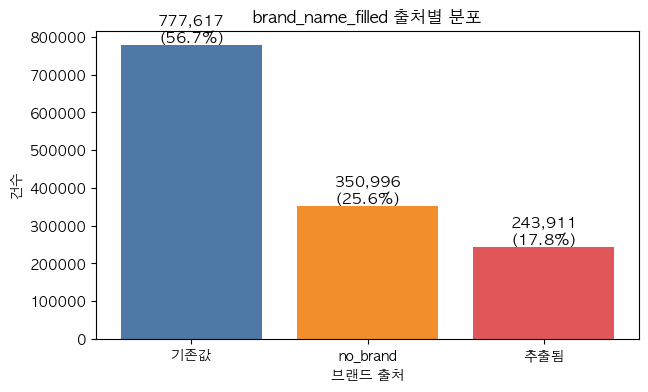

In [59]:
import matplotlib.pyplot as plt

# brand_name_filled가 기존 brand_name과 같은지, 새로 추출된 것인지, no_brand인지 구분
def get_brand_source(row):
    if row['brand_name_filled'] == "no_brand":
        return "no_brand"
    elif pd.isna(row['brand_name']) or str(row['brand_name']).lower() in ["nan", "none", ""]:
        return "추출됨"
    elif str(row['brand_name_filled']).lower() == str(row['brand_name']).lower():
        return "기존값"
    else:
        return "추출됨"

df['brand_source'] = df.apply(get_brand_source, axis=1)

# 각 그룹별 리스트 추출
추출된_브랜드 = df.loc[df['brand_source'] == "추출됨", 'brand_name_filled'].unique().tolist()
기존_브랜드 = df.loc[df['brand_source'] == "기존값", 'brand_name_filled'].unique().tolist()

# no_brand 비율 계산
no_brand_ratio = (df['brand_source'] == "no_brand").mean()

# 데이터프레임으로 요약
brand_source_counts = df['brand_source'].value_counts().reset_index()
brand_source_counts.columns = ['brand_source', 'count']
brand_source_counts['ratio'] = brand_source_counts['count'] / len(df)

display(brand_source_counts)

print("추출된 브랜드(일부):", 추출된_브랜드[:10])
print("기존 브랜드(일부):", 기존_브랜드[:10])
print(f"no_brand 비율: {no_brand_ratio:.2%}")

# 시각화
plt.figure(figsize=(7,4))
plt.bar(brand_source_counts['brand_source'], brand_source_counts['count'], color=['#4e79a7', '#f28e2b', '#e15759'])
plt.title("brand_name_filled 출처별 분포")
plt.ylabel("건수")
plt.xlabel("브랜드 출처")
for i, v in enumerate(brand_source_counts['count']):
    plt.text(i, v, f"{v:,}\n({brand_source_counts['ratio'][i]:.1%})", ha='center', va='bottom', fontsize=11)
plt.show()


In [22]:
df['brand_name_filled'].unique().tolist()

['mlb',
 'Razer',
 'Target',
 'no_brand',
 'Soffe',
 'Nike',
 'so',
 'Smashbox',
 "Victoria's Secret",
 'rue',
 'Scholastic',
 'UGG Australia',
 'Tarte',
 'Wet n Wild',
 'active',
 'Too Faced',
 'Anthropologie',
 'Torrid',
 'all',
 'FOREVER 21',
 'Air Jordan',
 'Apple',
 'LuLaRoe',
 'Hollister',
 'lularoe',
 'PINK',
 'Sephora',
 'barbie',
 'Under Armour',
 'Kylie Cosmetics',
 'The North Face',
 'Brandy Melville',
 'younique',
 'Michael Kors',
 'hot wheels',
 'Rae Dunn',
 'vintage',
 'Infantino',
 "Levi's®",
 'patagonia',
 'Barbie',
 'H&M',
 'Adidas',
 'Nostalgia Electrics',
 'vineyard vines',
 'Littlest Pet Shop',
 'pure',
 'Sea Wees',
 'Motherhood Maternity',
 'covergirl',
 'pink',
 'Melissa & Doug',
 'Pokemon',
 'Nintendo',
 'Silver Jeans Co.',
 'Gap',
 'gucci',
 'Lululemon',
 'adidas',
 'Fossil',
 'Merona',
 'Boulevard Boutique',
 'MARC JACOBS',
 'sperry',
 'Steve Madden',
 'No Boundaries',
 'Faded Glory',
 'Miss Me',
 'Salvatore Ferragamo',
 'Urban Outfitters',
 'primitive',
 'funk

### 6. 플랫폼 공식 기준 반영: 컨디션 등급/점수 & 가치 신호 추출

In [23]:
# === 컨디션/가치 신호 추출 (공식 기준 반영) ===

# 키워드 사전 (General + 카테고리 보정)
PATS = {
    "general": {
        "new": r"\bnwt\b|\bnib\b|\bnwb\b|\bunopened\b|\bsealed\b|\bbrand new\b|\bunused\b|\bwith tags\b|\bin (the )?box\b",
        "like_new": r"\blike new\b|\bnwot\b|\bnew without tags\b|\bno signs of wear\b|\bpristine\b|\bnear mint\b|\bexcellent\b",
        "good": r"\bgently used\b|\blightly used\b|\bminor flaws?\b",
        "fair": r"\bused\b.*\b(flaws?|defects?)\b|\bmultiple flaws?\b|\bdefects?\b",
        "poor": r"\bmajor flaws?\b|\bdamaged\b|\bfor parts\b|\bnon[- ]?functional\b|\bdoes ?n'?t work\b",
    },
    "clothing": {
        "good": r"\bpilling\b|\bstretching\b|\bloose threads?\b",
        "fair": r"\brips?\b|\blight stains?\b|\bpilling\b",
        "poor": r"\bholes?\b|\bstains?\b|\bfading\b|\bmissing (button|beads)\b",
    },
    "shoes": {
        "new": r"\bunworn\b.*\b(in (box|original box))\b",
        "like_new": r"\bunworn\b(?!.*box)\b|\bno creases\b|\bno scuff(s)? (on )?(treads?|soles?)\b",
        "good": r"\bslight wear on (sole|soles)\b|\blight creases\b|\bsmall scuffs?\b",
        "fair": r"\bmultiple major flaws?\b.*\bsole intact\b",
        "poor": r"\bsoles? (not )?intact\b|\blarge holes?\b|\bheavy scuffs?\b",
    },
    "electronics": {
        "new": r"\bunused\b|\bsealed\b|\boriginal packaging\b",
        "like_new": r"\blightly used\b.*\bfully functional\b(?!.*original packaging)",
        "good": r"\bgently used\b|\bminor cosmetic flaws?\b.*\bfully functional\b",
        "fair": r"\bmultiple cosmetic flaws?\b.*\bfunctional\b",
        "poor": r"\bmajor cosmetic flaws?\b|\bnon[- ]?functional\b|\bfor parts\b",
    },
    "furniture": {
        "new": r"\bunused\b|\bunbuilt\b|\bin (a )?box\b|\bpristine\b",
        "like_new": r"\blooks new\b|\bwithout any flaws?\b|\bno damage\b",
        "good": r"\bfew nearly undetectable flaws?\b",
        "fair": r"\bnoticeable flaws?\b|\bnicks?\b|\bsmall stains?\b",
        "poor": r"\bmajor rips?\b|\bscratches?\b|\bstains?\b|\bheavily worn\b",
    },
    "cellphone": {
        "new": r"\bunopened\b|\bnever used\b",
        "like_new": r"\blike new\b.*\bno scratches? on (the )?screen\b",
        "good": r"\bminor scratches? (on )?(body|screen)\b|\blight wear\b",
        "fair": r"\bvisible scratches?|dents? on body\b|\bscreen (scratches?|cracks?)\b.*\bfunctional\b",
        "poor": r"\bnon[- ]?functional\b|\bfor parts\b|\bmajor damage\b",
    }
}

DEFECTS = r"\bstain(s|ed)?\b|\bscratch(ed|es)?\b|\bscuff(ed|s)?\b|\bchip(ped|s)?\b|\bcrack(ed|s)?\b|\btear(s|ed)?\b|\brip(ped|s)?\b|\bhole(s)?\b|\bdent(s|ed)?\b|\bbroken\b|\bmissing\b|\bdefect(ive)?\b"
PROOFS  = r"\bauthentic\b|\bgenuine\b|\blegit\b|\b(receipt|proof of purchase)\b|\boriginal box\b|\bbox included\b|\bwith box\b|\btags included\b|\btag(s)? attached\b"
RARITY  = r"\blimited edition\b|\brare\b|\bhtf\b|\bgrail\b"
ENV     = r"\bsmoke[- ]?free\b|\bpet[- ]?free\b|\bworn once\b|\bused once\b|\bbundle\b|\bfree shipping\b"

RETAIL_PATTERNS = [
    r"\b(retail|original(ly)?|msrp|bought for|paid)\s*(for|price|at|:)?\s*\$?\s*([0-9]{2,5})(?:\.[0-9]{2})?\b",
    r"\$\s*([0-9]{2,5})(?:\.[0-9]{2})?\s*(retail|msrp)\b",
]

def pick_domain(cat1: str, cat2: str):
    c1 = str(cat1 or "")
    c2 = str(cat2 or "")
    key = "general"
    if "Shoe" in c2: key = "shoes"
    elif "Phone" in c1 or "Phone" in c2: key = "cellphone"
    elif "Electr" in c1 or "Electr" in c2 or "Comput" in c2: key = "electronics"
    elif "Furniture" in c1 or "Furniture" in c2: key = "furniture"
    elif "Cloth" in c1 or "Cloth" in c2 or "Women" in c1 or "Men" in c1: key = "clothing"
    return key

def extract_condition_level(name: str, desc: str, cat1: str, cat2: str):
    t = normalize_text(f"{name} {desc}")
    domain = pick_domain(cat1, cat2)
    dom = PATS.get(domain, {})
    gen = PATS["general"]

    # 우선순위: New > Like New > Good > Fair > Poor
    level = 0
    if re.search(dom.get("new", "") or gen["new"], t): level = max(level, 5)
    if re.search(dom.get("like_new", "") or gen["like_new"], t): level = max(level, 4 if level<5 else 5)
    if re.search(dom.get("good", "") or gen["good"], t): level = max(level, 3 if level<5 else level)
    if re.search(dom.get("fair", "") or gen["fair"], t): level = max(level, 2 if level<4 else level)
    if re.search(dom.get("poor", "") or gen["poor"], t): level = max(level, 1 if level<3 else level)

    # NWOT는 Like New로 (공식 가이드 반영)
    if re.search(r"\bnwot\b", t): 
        level = max(level, 4)

    defects_cnt = len(re.findall(DEFECTS, t))
    proofs_cnt  = len(re.findall(PROOFS,  t))
    rarity_cnt  = len(re.findall(RARITY,  t))
    env_flags   = 1 if re.search(ENV, t) else 0

    # 점수: 보수적으로 한 단계 낮춰도 무방 (과대평가 방지)
    # 여기서는 공식 가이드를 반영한 보정 없이 단순식 사용
    condition_score = 0.5*max(1, level) + 0.5*min(2, proofs_cnt) - 0.4*min(2, defects_cnt) + 0.2*min(2, rarity_cnt)

    # 리테일/원가 앵커 추출
    def extract_msrp_num(s: str):
        for p in RETAIL_PATTERNS:
            m = re.search(p, s)
            if m:
                nums = re.findall(r"([0-9]{2,5})(?:\.[0-9]{2})?", m.group(0))
                if nums:
                    try:
                        return float(nums[-1])
                    except:
                        return np.nan
        return np.nan
    anchor_price = extract_msrp_num(t)

    return level if level>0 else 0, condition_score, defects_cnt, proofs_cnt, rarity_cnt, env_flags, anchor_price

log("Extracting condition/value signals...")
cond_cols = ["condition_level","condition_score","defects_cnt","proofs_cnt","rarity_cnt","env_flags","stated_retail_price"]
vals = df.apply(lambda r: extract_condition_level(r["name"], r["item_description"], r["cat1"], r["cat2"]), axis=1)
vals = np.array(list(vals))
for i,c in enumerate(cond_cols):
    df[c] = vals[:,i]

df["stated_retail_price_log"] = np.log1p(df["stated_retail_price"].astype(float))


[INFO] Extracting condition/value signals...


### 7. 스무딩 타깃 인코딩(TE) & 5분위 등급(브랜드/카테고리/컨디션)

In [24]:
# === 스무딩 TE & 5분위 등급 ===
def smoothed_mean_by_group(keys: pd.Series, y: np.ndarray, k=50, min_count=20):
    ser = pd.Series(keys).astype(str)
    agg = pd.DataFrame({"y": y, "key": ser}).groupby("key")["y"].agg(["mean","count"])
    gm = float(np.mean(y))
    agg["smoothed"] = (agg["count"]*agg["mean"] + k*gm) / (agg["count"]+k)
    # small groups 더 강하게 전역으로 수렴
    small = agg["count"] < min_count
    agg.loc[small, "smoothed"] = (agg.loc[small, "count"]*agg.loc[small, "mean"] + (k*2)*gm) / (agg.loc[small, "count"] + (k*2))
    return agg["smoothed"], gm

def fit_quintile_grades(sm_series: pd.Series):
    vals = sm_series.values
    cuts = np.quantile(vals, [0,.2,.4,.6,.8,1.0])
    def grade(v): return int(np.digitize(v, cuts[1:-1], right=True)) + 1  # 1~5
    return {k: grade(v) for k,v in sm_series.items()}, cuts

# 70/30 split (여기서 TE/등급 fit은 train에서만!)
FEATURE_BASE = ["name","item_description","item_condition_id","shipping","brand_name_filled","cat2",
                "condition_level","condition_score","stated_retail_price_log"]

X = df[FEATURE_BASE].copy()
y = df["y"].values

try:
    X_tr, X_va, y_tr, y_va = train_test_split(
        X, y, test_size=VALID_SIZE, random_state=RANDOM_STATE, stratify=df["cat2"]
    )
except Exception:
    X_tr, X_va, y_tr, y_va = train_test_split(
        X, y, test_size=VALID_SIZE, random_state=RANDOM_STATE
    )

# TE fit
brand_sm, gm = smoothed_mean_by_group(X_tr["brand_name_filled"], y_tr, k=60, min_count=25)
cat2_sm,   _ = smoothed_mean_by_group(X_tr["cat2"], y_tr, k=60, min_count=25)
cond_sm,   _ = smoothed_mean_by_group(X_tr["condition_level"], y_tr, k=30, min_count=10)

brand_te_map = brand_sm.to_dict()
cat2_te_map  = cat2_sm.to_dict()
cond_te_map  = cond_sm.to_dict()

def map_te(series, mapping, gm):
    return pd.Series(series).map(mapping).fillna(gm).astype(float).values

# quintile grades (해석용)
brand_grade_map, brand_cuts = fit_quintile_grades(brand_sm)
cat2_grade_map,  cat2_cuts  = fit_quintile_grades(cat2_sm)
cond_grade_map,  cond_cuts  = fit_quintile_grades(cond_sm)

def map_grade(series, mapping, default=3):
    return pd.Series(series).map(mapping).fillna(default).astype(int).values

# train transform
def build_numeric_frame(dfp):
    out = pd.DataFrame(index=dfp.index)
    out["item_condition_id"] = dfp["item_condition_id"].astype(float).values
    out["shipping"] = dfp["shipping"].astype(float).values
    out["condition_level"] = dfp["condition_level"].astype(float).values
    out["condition_score"] = dfp["condition_score"].astype(float).values
    out["stated_retail_price_log"] = dfp["stated_retail_price_log"].astype(float).fillna(0.0).values
    out["name_len"] = dfp["name"].astype(str).str.len().astype(float).values
    out["desc_len"] = dfp["item_description"].astype(str).str.len().astype(float).values
    out["name_wc"]  = dfp["name"].astype(str).apply(safe_len_words).astype(float).values
    out["desc_wc"]  = dfp["item_description"].astype(str).apply(safe_len_words).astype(float).values
    return out

num_tr = build_numeric_frame(X_tr)
num_va = build_numeric_frame(X_va)

# add TE
num_tr["brand_te"] = map_te(X_tr["brand_name_filled"], brand_te_map, gm)
num_tr["cat2_te"]  = map_te(X_tr["cat2"],              cat2_te_map,  gm)
num_tr["cond_te"]  = map_te(X_tr["condition_level"],   cond_te_map,  gm)

num_va["brand_te"] = map_te(X_va["brand_name_filled"], brand_te_map, gm)
num_va["cat2_te"]  = map_te(X_va["cat2"],              cat2_te_map,  gm)
num_va["cond_te"]  = map_te(X_va["condition_level"],   cond_te_map,  gm)

# add grades
num_tr["brand_grade"] = map_grade(X_tr["brand_name_filled"], brand_grade_map)
num_tr["cat2_grade"]  = map_grade(X_tr["cat2"],              cat2_grade_map)
num_tr["cond_grade"]  = map_grade(X_tr["condition_level"],   cond_grade_map)

num_va["brand_grade"] = map_grade(X_va["brand_name_filled"], brand_grade_map)
num_va["cat2_grade"]  = map_grade(X_va["cat2"],              cat2_grade_map)
num_va["cond_grade"]  = map_grade(X_va["condition_level"],   cond_grade_map)


### 8. 텍스트 피처: TF‑IDF → SVD (fold leakage 방지: train fit → valid transform)

In [29]:
# === TE (brand / cat2 / condition only) & grade(선택) 재생성 ===
import numpy as np
import pandas as pd

def smoothed_mean_by_group(keys: pd.Series, y: np.ndarray, k=60, min_count=25):
    ser = pd.Series(keys).astype(str)
    agg = pd.DataFrame({"y": y, "key": ser}).groupby("key")["y"].agg(["mean","count"])
    gm = float(np.mean(y))
    agg["smoothed"] = (agg["count"]*agg["mean"] + k*gm) / (agg["count"]+k)
    small = agg["count"] < min_count
    agg.loc[small, "smoothed"] = (agg.loc[small, "count"]*agg["mean"] + (k*2)*gm) / (agg.loc[small, "count"] + (k*2))
    return agg["smoothed"], gm

def map_te(series, mapping, gm):
    return pd.Series(series).map(mapping).fillna(gm).astype(float).values

def fit_quintile_grades(sm_series: pd.Series):
    vals = sm_series.values
    cuts = np.quantile(vals, [0,.2,.4,.6,.8,1.0])
    def grade(v): return int(np.digitize(v, cuts[1:-1], right=True)) + 1
    return {k: grade(v) for k,v in sm_series.items()}, cuts

def map_grade(series, mapping, default=3):
    return pd.Series(series).map(mapping).fillna(default).astype(int).values

def build_numeric_frame(dfp: pd.DataFrame):
    out = pd.DataFrame(index=dfp.index)
    out["item_condition_id"] = dfp["item_condition_id"].astype(float).values
    out["shipping"] = dfp["shipping"].astype(float).values
    out["condition_level"] = dfp.get("condition_level", 0).astype(float).values
    out["condition_score"] = dfp.get("condition_score", 0.0).astype(float).values
    out["stated_retail_price_log"] = dfp.get("stated_retail_price_log", 0.0).astype(float).fillna(0.0).values
    out["name_len"] = dfp["name"].astype(str).str.len().astype(float).values
    out["desc_len"] = dfp["item_description"].astype(str).str.len().astype(float).values
    out["name_wc"]  = dfp["name"].astype(str).str.split().apply(len).astype(float).values
    out["desc_wc"]  = dfp["item_description"].astype(str).str.split().apply(len).astype(float).values
    return out

# --- 분할 전에 X에 반드시 들어가 있어야 하는 컬럼만 사용 ---
# FEATURE_BASE 예시: ["name","item_description","item_condition_id","shipping","brand_name_filled","cat2","condition_level","condition_score","stated_retail_price_log"]
# X_tr, X_va, y_tr, y_va 가 이미 존재한다고 가정

# brand key (보강된 컬럼이 있으면 우선 사용)
brand_key_tr = (X_tr["brand_name_filled"] if "brand_name_filled" in X_tr else X_tr["brand_name"])
brand_key_va = (X_va["brand_name_filled"] if "brand_name_filled" in X_va else X_va["brand_name"])

# TE fit on train (brand / cat2 / condition)
brand_sm, gm = smoothed_mean_by_group(brand_key_tr, y_tr, k=80, min_count=30)
cat2_sm,   _ = smoothed_mean_by_group(X_tr["cat2"], y_tr, k=80, min_count=30)
cond_sm,   _ = smoothed_mean_by_group(X_tr.get("condition_level", pd.Series([0]*len(X_tr))), y_tr, k=40, min_count=10)

brand_te_map = brand_sm.to_dict()
cat2_te_map  = cat2_sm.to_dict()
cond_te_map  = cond_sm.to_dict()

# (선택) 해석용 등급
brand_grade_map, _ = fit_quintile_grades(brand_sm)
cat2_grade_map,  _ = fit_quintile_grades(cat2_sm)
cond_grade_map,  _ = fit_quintile_grades(cond_sm)

# 수치 프레임 생성 & TE/등급 주입
num_tr = build_numeric_frame(X_tr)
num_va = build_numeric_frame(X_va)

num_tr["brand_te"] = map_te(brand_key_tr, brand_te_map, gm)
num_tr["cat2_te"]  = map_te(X_tr["cat2"],  cat2_te_map,  gm)
num_tr["cond_te"]  = map_te(X_tr.get("condition_level", pd.Series([0]*len(X_tr))), cond_te_map, gm)

num_va["brand_te"] = map_te(brand_key_va, brand_te_map, gm)
num_va["cat2_te"]  = map_te(X_va["cat2"],  cat2_te_map,  gm)
num_va["cond_te"]  = map_te(X_va.get("condition_level", pd.Series([0]*len(X_va))), cond_te_map, gm)

# (선택) 등급도 보관 (모델 입력에는 TE 위주 권장)
num_tr["brand_grade"] = map_grade(brand_key_tr, brand_grade_map)
num_tr["cat2_grade"]  = map_grade(X_tr["cat2"],  cat2_grade_map)
num_tr["cond_grade"]  = map_grade(X_tr.get("condition_level", pd.Series([0]*len(X_tr))), cond_grade_map)

num_va["brand_grade"] = map_grade(brand_key_va, brand_grade_map)
num_va["cat2_grade"]  = map_grade(X_va["cat2"],  cat2_grade_map)
num_va["cond_grade"]  = map_grade(X_va.get("condition_level", pd.Series([0]*len(X_va))), cond_grade_map)

log(f"TE ready (brand/cat2/condition). num_tr/num_va = {num_tr.shape} / {num_va.shape}")


[INFO] TE ready (brand/cat2/condition). num_tr/num_va = (960766, 15) / (411758, 15)


### 9. 모델 학습(베이스라인: HistGradientBoosting) & 검증 성능

In [30]:
# === 텍스트 피처: TF-IDF(20k, 1-3gram, min_df=3) → SVD(256) ===
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

text_tr = (X_tr["name"].astype(str) + " " + X_tr["item_description"].astype(str)).values
text_va = (X_va["name"].astype(str) + " " + X_va["item_description"].astype(str)).values

tfidf = TfidfVectorizer(
    max_features=20000, ngram_range=(1,3), min_df=3, stop_words="english"
)
Xtr_tfidf = tfidf.fit_transform(text_tr)
Xva_tfidf = tfidf.transform(text_va)

svd = TruncatedSVD(n_components=256, random_state=RANDOM_STATE)
Xtr_svd = svd.fit_transform(Xtr_tfidf)
Xva_svd = svd.transform(Xva_tfidf)

# 최종 피처 매트릭스
Xtr = np.hstack([num_tr.values, Xtr_svd])
Xva = np.hstack([num_va.values, Xva_svd])

log(f"Train/Valid feature shapes: {Xtr.shape} / {Xva.shape}")


[INFO] Train/Valid feature shapes: (960766, 271) / (411758, 271)


### 10. test 데이터 동일 파이프라인 추론

In [36]:
# === LightGBM 학습 & 검증 (sklearn API, 버전 호환) ===
# 필요시: !pip install lightgbm
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, joblib
from pathlib import Path

log("Training LightGBM (scikit-learn API)...")

# 공통 하이퍼파라미터
base_kwargs = dict(
    objective="regression",
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    min_data_in_leaf=50,
    n_estimators=5000,
    random_state=RANDOM_STATE
)

lgbm = LGBMRegressor(**base_kwargs)

# --- 버전 호환: 콜백이 되면 콜백 사용, 아니면 early_stopping_rounds 인자로 대체 ---
used_callbacks = False
try:
    cb = [lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=200)]
    lgbm.fit(
        Xtr, y_tr,
        eval_set=[(Xva, y_va)],
        eval_metric="rmse",
        callbacks=cb
    )
    used_callbacks = True
except TypeError:
    # 일부 구버전은 callbacks 미지원 → early_stopping_rounds/verbose 사용
    lgbm = LGBMRegressor(**base_kwargs)
    lgbm.fit(
        Xtr, y_tr,
        eval_set=[(Xva, y_va)],
        eval_metric="rmse",
        early_stopping_rounds=200,
        verbose=200
    )

# 예측 (best_iteration_가 있으면 사용)
best_iter = getattr(lgbm, "best_iteration_", None)
pred_log   = lgbm.predict(Xva, num_iteration=best_iter)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_va)

# 지표 (원스케일)
rmse = np.sqrt(mean_squared_error(true_price, pred_price))
mae  = mean_absolute_error(true_price, pred_price)
log(f"[LGBMRegressor] Validation RMSE: {rmse:,.3f}")
log(f"[LGBMRegressor] Validation MAE : {mae:,.3f}")

# (참고) 로그 스케일 지표
rmse_log = np.sqrt(mean_squared_error(y_va, pred_log))
mae_log  = mean_absolute_error(y_va, pred_log)
log(f"[LGBMRegressor] Validation RMSE_log: {rmse_log:.4f}")
log(f"[LGBMRegressor] Validation MAE_log : {mae_log:.4f}")

# 아티팩트 저장
ARTIFACT_DIR = Path("./artifacts"); ARTIFACT_DIR.mkdir(exist_ok=True)
joblib.dump(lgbm, ARTIFACT_DIR / "model_lgbm_sklearn.joblib")
joblib.dump(tfidf, ARTIFACT_DIR / "tfidf.joblib")
joblib.dump(svd,   ARTIFACT_DIR / "svd.joblib")
joblib.dump({
    "brand_te_map": brand_te_map,
    "cat2_te_map":  cat2_te_map,
    "cond_te_map":  cond_te_map,
    "global_mean":  float(np.mean(y_tr)),
    "brand_grade_map": brand_grade_map,
    "cat2_grade_map":  cat2_grade_map,
    "cond_grade_map":  cond_grade_map
}, ARTIFACT_DIR / "encoders.joblib")
log("Artifacts saved (LGBMRegressor)")


[INFO] Training LightGBM (scikit-learn API)...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] 

In [58]:
# === 비교용 DataFrame 생성 ===
# 원본에서 validation 인덱스 추출
val_ids = X_va.index  # train_id 인덱스

# 비교 데이터프레임
compare_df = pd.DataFrame({
    "train_id": df.loc[val_ids, "train_id"].values,
    "true_price": true_price,
    "pred_price": pred_price
})

# 오차 컬럼 추가
compare_df["abs_error"] = (compare_df["true_price"] - compare_df["pred_price"]).abs()
compare_df["pct_error"] = compare_df["abs_error"] / compare_df["true_price"]

compare_df.head(10)


,train_id,true_price,pred_price,abs_error,pct_error
0,521570,23.0,14.777840,8.222160,0.357485
1,1321489,16.0,25.360687,9.360687,0.585043
2,1307017,26.0,16.761980,9.238020,0.355308
3,1466258,12.0,22.821700,10.821700,0.901808
4,490412,25.0,19.820127,5.179873,0.207195
5,1191205,39.0,11.490847,27.509153,0.705363
6,156692,6.0,11.908307,5.908307,0.984718
7,1422478,22.0,18.902084,3.097916,0.140814
8,609911,32.0,17.717579,14.282421,0.446326
9,865133,10.0,9.155578,0.844422,0.084442


In [34]:
import sys
print(sys.executable)

/opt/anaconda3/envs/py311/bin/python


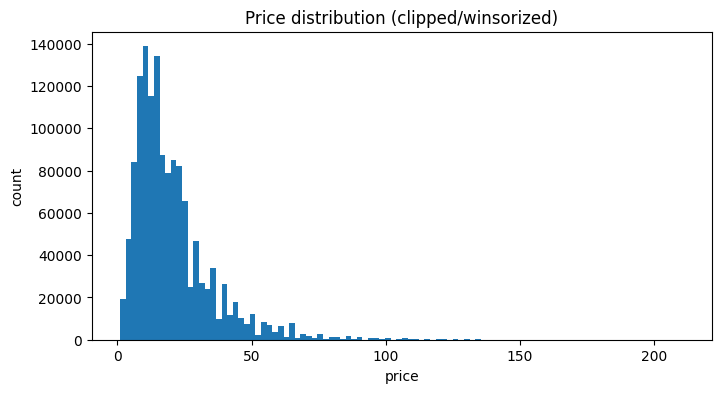

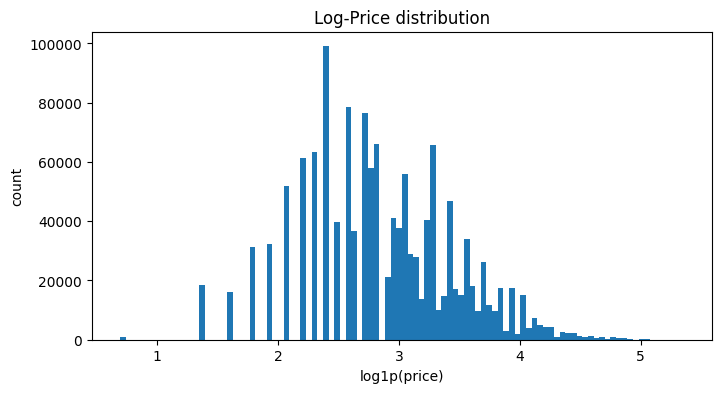

In [38]:
import matplotlib.pyplot as plt

# === 5-1. Price distributions ===
fig = plt.figure(figsize=(8,4))
plt.hist(df["price"], bins=100)
plt.title("Price distribution (clipped/winsorized)")
plt.xlabel("price"); plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(8,4))
plt.hist(df["y"], bins=100)
plt.title("Log-Price distribution")
plt.xlabel("log1p(price)"); plt.ylabel("count")
plt.show()

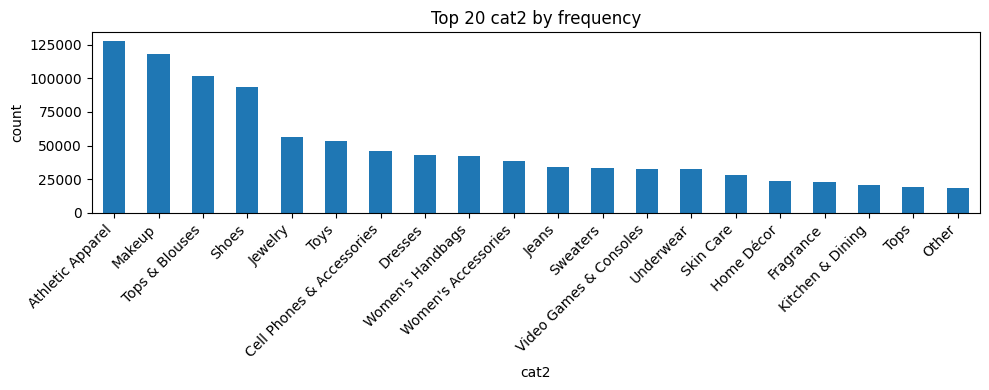

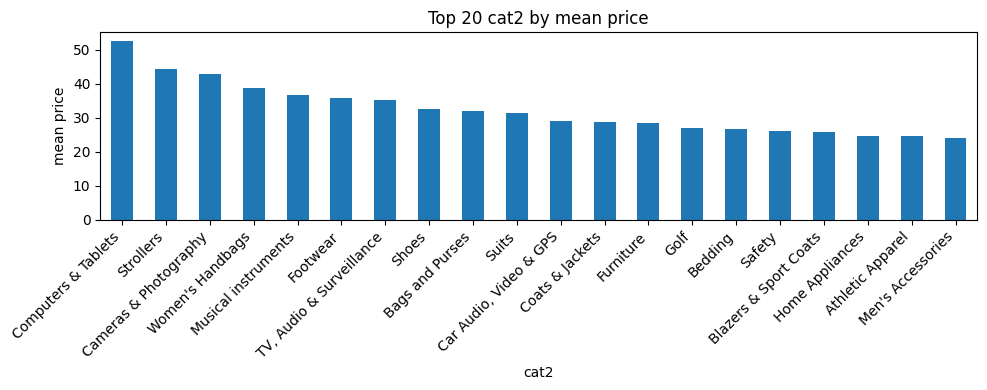

In [39]:
# === 5-2. cat2 topN frequency & mean price ===
topN = 20
cat2_freq = df["cat2"].value_counts().head(topN)
cat2_mean = df.groupby("cat2")["price"].mean().sort_values(ascending=False).head(topN)

fig = plt.figure(figsize=(10,4))
cat2_freq.plot(kind="bar")
plt.title(f"Top {topN} cat2 by frequency"); plt.xlabel("cat2"); plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

fig = plt.figure(figsize=(10,4))
cat2_mean.plot(kind="bar")
plt.title(f"Top {topN} cat2 by mean price")
plt.xlabel("cat2"); plt.ylabel("mean price")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

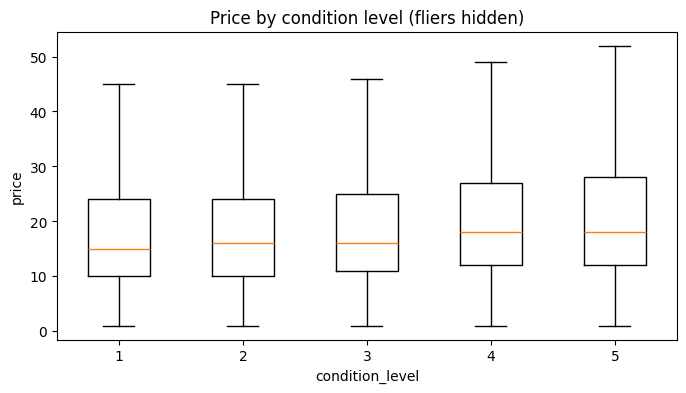

In [40]:
# === 5-3. Condition level vs price ===
cond_box = [df.loc[df["condition_level"]==i, "price"].values for i in [1,2,3,4,5]]
fig = plt.figure(figsize=(8,4))
plt.boxplot(cond_box, labels=[1,2,3,4,5], showfliers=False)
plt.title("Price by condition level (fliers hidden)")
plt.xlabel("condition_level"); plt.ylabel("price")
plt.show()

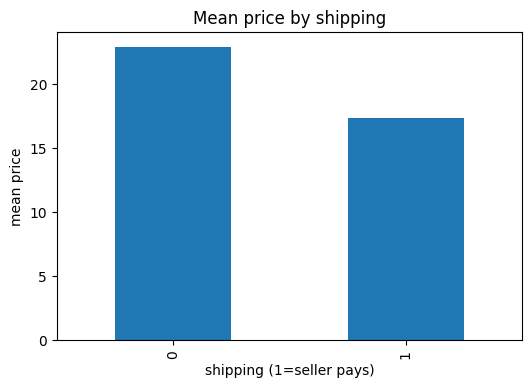

In [41]:
# === 5-4. Shipping vs price ===
fig = plt.figure(figsize=(6,4))
df.groupby("shipping")["price"].mean().plot(kind="bar")
plt.title("Mean price by shipping")
plt.xlabel("shipping (1=seller pays)"); plt.ylabel("mean price")
plt.show()

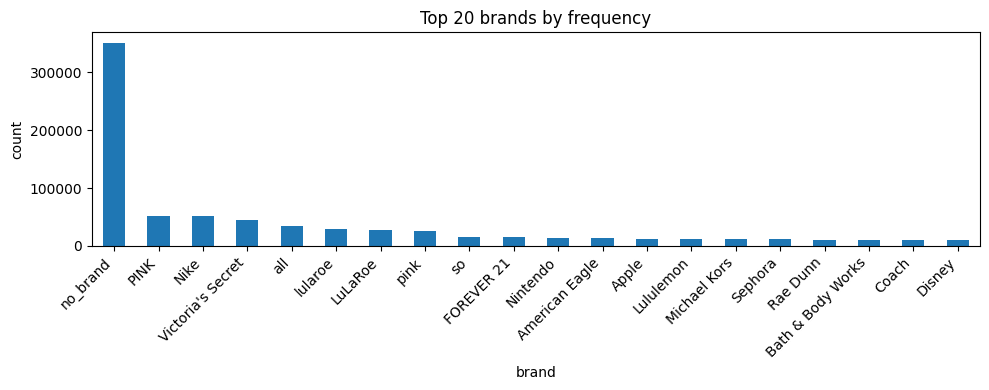

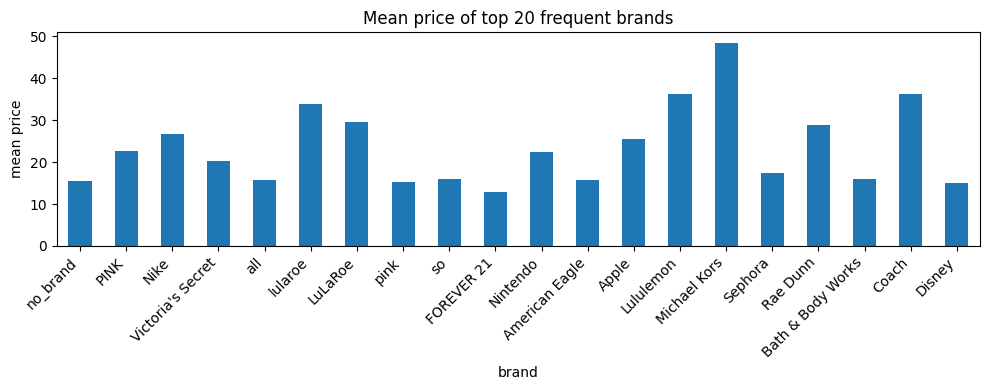

In [42]:
# === 5-5. Top brands by mean price and count ===
topN = 20
brand_cnt = df["brand_name_filled"].value_counts().head(topN)
brand_mean = (df.groupby("brand_name_filled")["price"].mean()
              .loc[brand_cnt.index])

fig = plt.figure(figsize=(10,4))
brand_cnt.plot(kind="bar")
plt.title(f"Top {topN} brands by frequency")
plt.xlabel("brand"); plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

fig = plt.figure(figsize=(10,4))
brand_mean.plot(kind="bar")
plt.title(f"Mean price of top {topN} frequent brands")
plt.xlabel("brand"); plt.ylabel("mean price")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

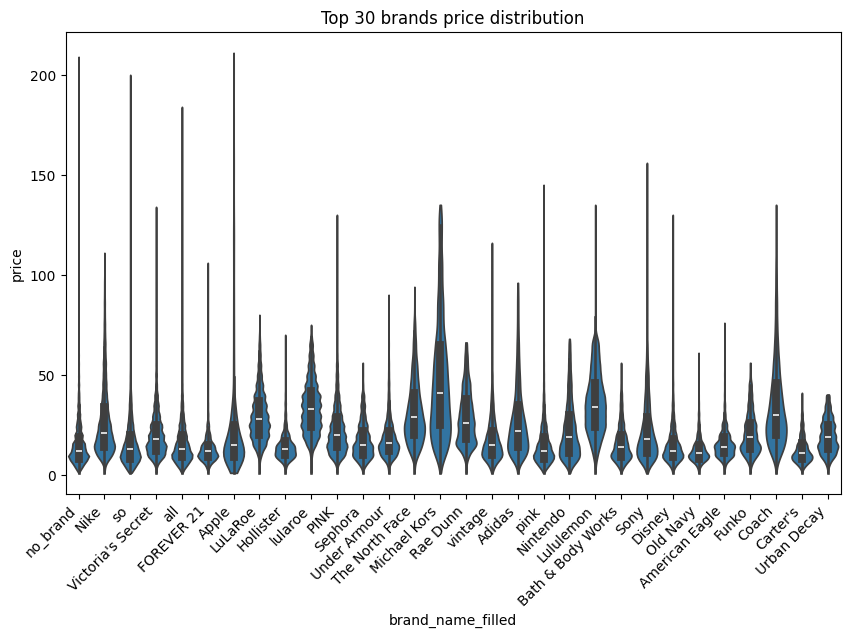

In [43]:
# 고급 브랜드 vs 저가 브랜드 군집
import seaborn as sns
top_brands = df["brand_name_filled"].value_counts().head(30).index
brand_prices = df[df["brand_name_filled"].isin(top_brands)][["brand_name_filled","price"]]

fig = plt.figure(figsize=(10,6))
sns.violinplot(x="brand_name_filled", y="price", data=brand_prices, scale="width", cut=0)
plt.xticks(rotation=45, ha="right")
plt.title("Top 30 brands price distribution")
plt.show()

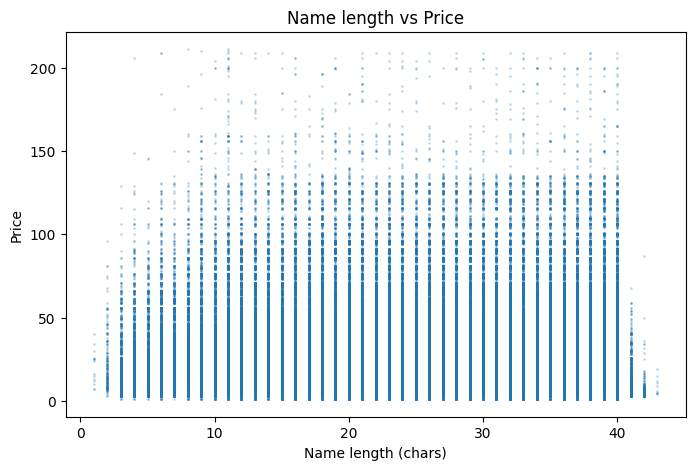

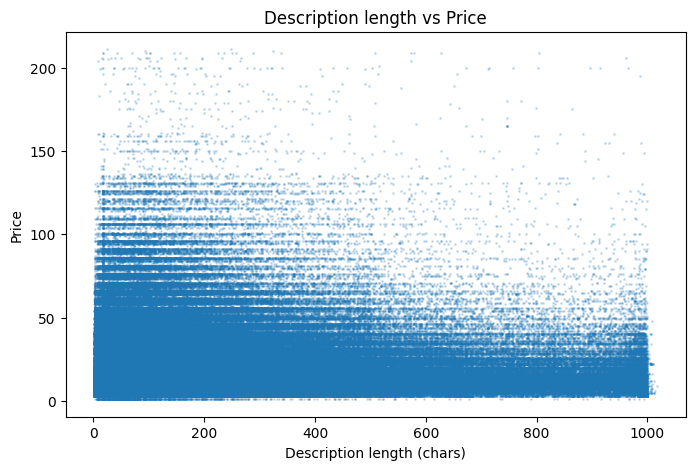

In [44]:
fig = plt.figure(figsize=(8,5))
plt.scatter(df["name"].str.len(), df["price"], alpha=0.2, s=1)
plt.xlabel("Name length (chars)")
plt.ylabel("Price")
plt.title("Name length vs Price")
plt.show()

fig = plt.figure(figsize=(8,5))
plt.scatter(df["item_description"].str.len(), df["price"], alpha=0.2, s=1)
plt.xlabel("Description length (chars)")
plt.ylabel("Price")
plt.title("Description length vs Price")
plt.show()

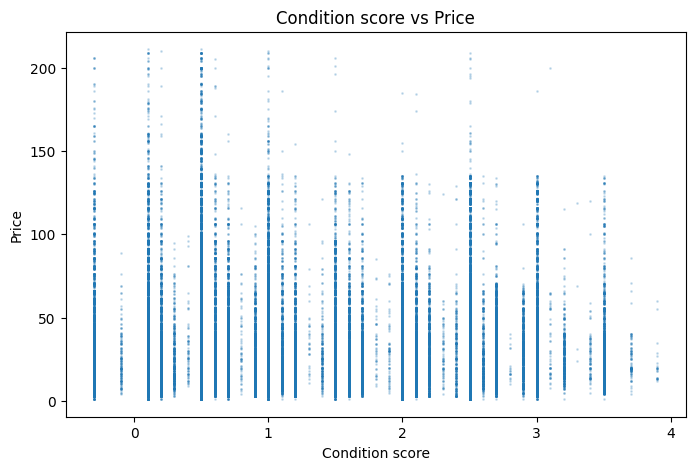

In [45]:
fig = plt.figure(figsize=(8,5))
plt.scatter(df["condition_score"], df["price"], alpha=0.2, s=1)
plt.xlabel("Condition score"); plt.ylabel("Price")
plt.title("Condition score vs Price")
plt.show()

In [54]:
# LightGBM 예측
pred_lgbm_log = lgbm.predict(Xva, num_iteration=lgbm.best_iteration_)
pred_lgbm = np.expm1(pred_lgbm_log)

# Ridge 예측 (있다면)
pred_ridge_log = ridge.predict(Xva_tfidf)
pred_ridge = np.expm1(pred_ridge_log)

# 앙상블 blending (비율은 검증 RMSE 기반으로 조정)
pred_blend = 0.6 * pred_lgbm + 0.4 * pred_ridge

# 실제값
true_price = np.expm1(y_va)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


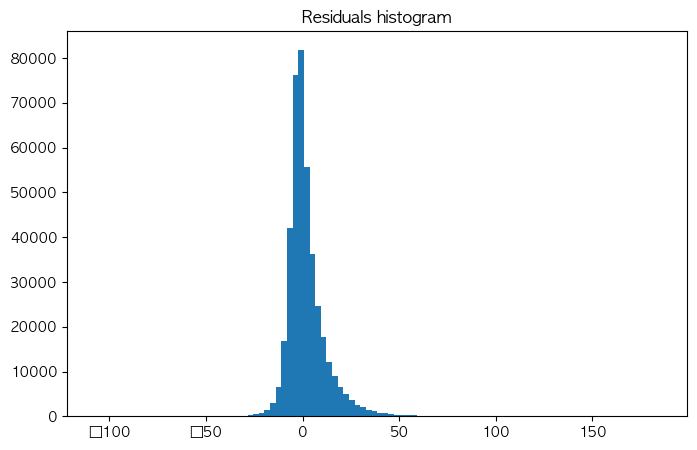

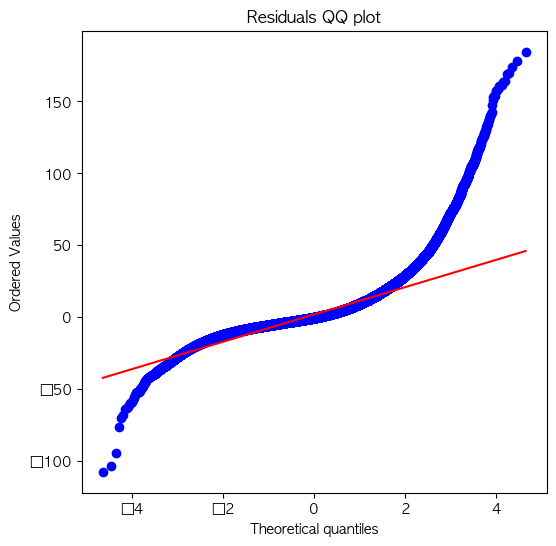

In [55]:
import scipy.stats as stats

resid = true_price - pred_blend
fig = plt.figure(figsize=(8,5))
plt.hist(resid, bins=100)
plt.title("Residuals histogram")
plt.show()

fig = plt.figure(figsize=(6,6))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Residuals QQ plot")
plt.show()

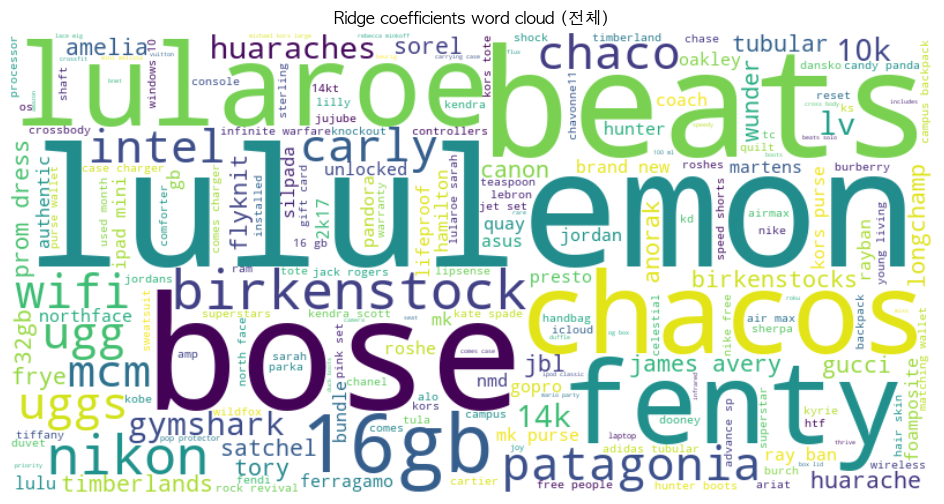

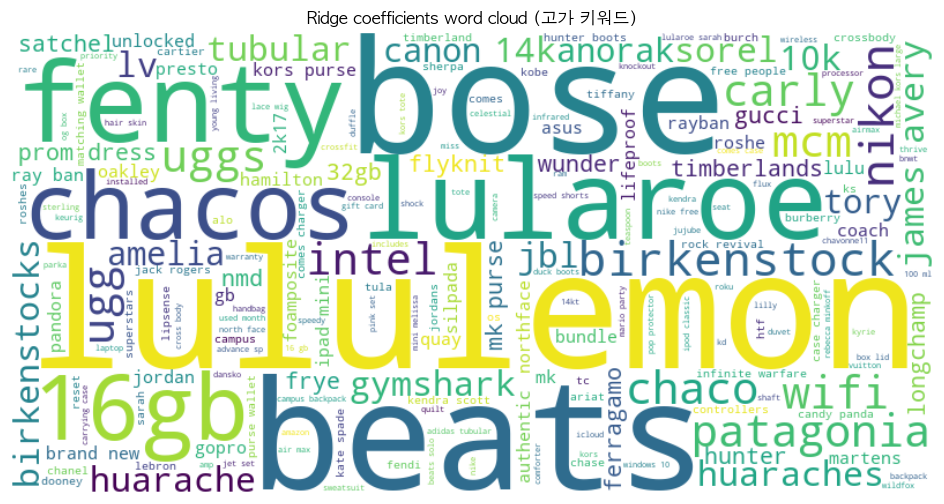

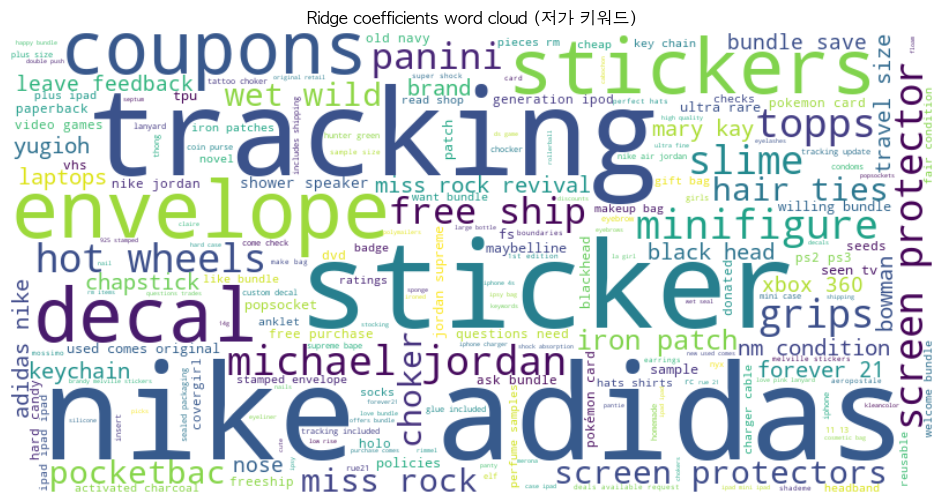

In [53]:
# === Ridge 학습 (텍스트 전용) ===
from sklearn.linear_model import Ridge

# TF-IDF는 이미 tfidf.fit() 되어 있고, Xtr_tfidf / Xva_tfidf 도 만들어져 있어야 함
ridge = Ridge(alpha=8.0, random_state=RANDOM_STATE)
ridge.fit(Xtr_tfidf, y_tr)

# Ridge 예측 (검증용)
pred_ridge_log = ridge.predict(Xva_tfidf)
pred_ridge = np.expm1(pred_ridge_log)

# 계수 추출
feature_names = np.array(tfidf.get_feature_names_out())
coefs = ridge.coef_.ravel()
coef_dict = dict(zip(feature_names, coefs))

# === 워드클라우드: 전체 계수 ===
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import platform
import matplotlib
if platform.system() == 'Darwin':  # 맥북(맥OS)에서 한글 깨짐 방지
    matplotlib.rc('font', family='AppleGothic')
wordcloud = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Ridge coefficients word cloud (전체)")
plt.show()

# === 워드클라우드: 고가 키워드만 ===
coef_pos = {k: v for k,v in coef_dict.items() if v > 0}
wordcloud_pos = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(coef_pos)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Ridge coefficients word cloud (고가 키워드)")
plt.show()

# === 워드클라우드: 저가 키워드만 ===
coef_neg = {k: abs(v) for k,v in coef_dict.items() if v < 0}
wordcloud_neg = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(coef_neg)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Ridge coefficients word cloud (저가 키워드)")
plt.show()

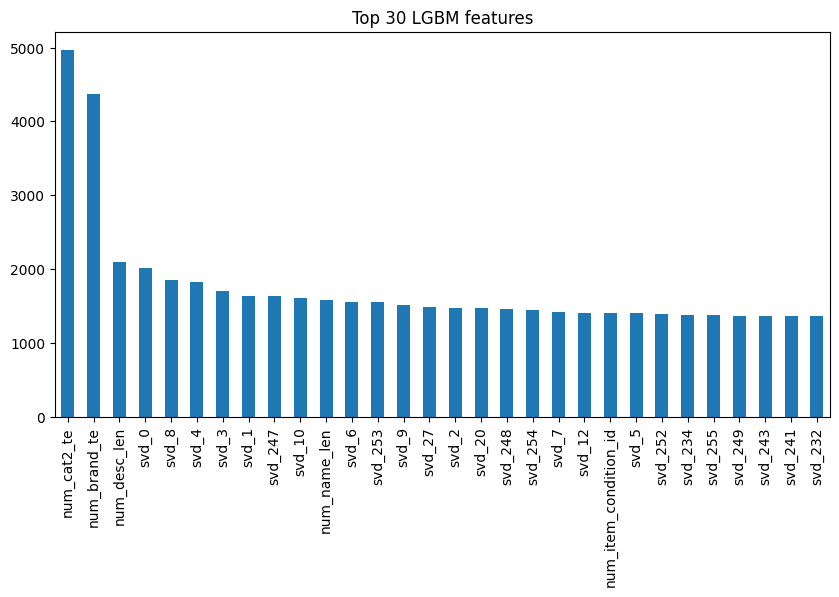

In [49]:
feat_names = [f"num_{c}" for c in num_tr.columns] + [f"svd_{i}" for i in range(Xtr_svd.shape[1])]
imp = pd.Series(lgbm.feature_importances_, index=feat_names).sort_values(ascending=False).head(30)
imp.plot(kind="bar", figsize=(10,5))
plt.title("Top 30 LGBM features")
plt.show()

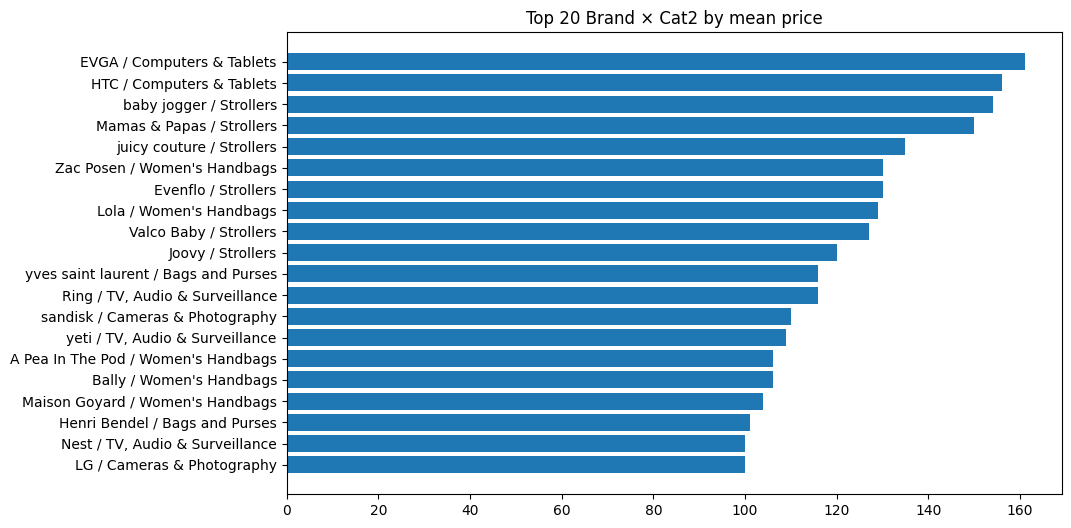

In [50]:
cross_stats = df.groupby(["brand_name_filled","cat2"])["price"].mean().reset_index()
top_cross = cross_stats.sort_values("price", ascending=False).head(20)

fig = plt.figure(figsize=(10,6))
plt.barh(top_cross["brand_name_filled"] + " / " + top_cross["cat2"], top_cross["price"])
plt.gca().invert_yaxis()
plt.title("Top 20 Brand × Cat2 by mean price")
plt.show()

In [56]:
df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat1,cat2,...,y,brand_name_filled,condition_level,condition_score,defects_cnt,proofs_cnt,rarity_cnt,env_flags,stated_retail_price,stated_retail_price_log
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,nan,10.0,1,No description yet,Men,Tops,...,2.397895,mlb,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,3.970292,Razer,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,2.397895,Target,1.0,0.1,1.0,0.0,0.0,0.0,NaN,NaN
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,nan,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,3.583519,no_brand,5.0,2.5,0.0,0.0,0.0,1.0,NaN,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,nan,44.0,0,Complete with certificate of authenticity,Women,Jewelry,...,3.806662,no_brand,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372519,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",Women,Dresses,...,3.044522,Free People,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN
1372520,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,...,2.708050,Disney,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN
1372521,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,nan,12.0,0,"Used once or twice, still in great shape.",Sports & Outdoors,Exercise,...,2.564949,no_brand,0.0,0.5,0.0,0.0,0.0,1.0,NaN,NaN
1372522,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,nan,45.0,1,There is 2 of each one that you see! So 2 red ...,Home,Home Décor,...,3.828641,so,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN
